<a href="https://colab.research.google.com/github/RaquelGrosman/BigD/blob/master/week2_STEP_1_tess_exomast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="top_page"></a>
# Exoplanet Data and TESS Light Curves Using Python Requests

Exo.mast provides several API tools to obtain the planet parameter information for exoplanets available via that interface. Also, when available you can use these tools to download and plot the TESS light curves.

It is all done via a RESTful API, but it is not available through astroquery. We will show you how to construct the url, do the ***get*** Request and manipulate the resulting information.

[Imports](#imports)<br>
[Get Planet Names](#names)<br>
[Get Planet Properties](#props)<br>
[Get TCE Light Curve](#lightcurve)<br>
[Get TCE Phase Folded Plot](#phased)<br>
[Additional Resources](#additional)<br>
[About This Notebook](#about)<br>


***

<a id="imports"></a>
## Import statements
We need the following python packages to do the imports.
- **numpy** for array manipulation
- **requests** to make the RESTful API get requests
- **matplotlib.pyplot** to plot
- **pandas** to manipulate data
- **IPython.display.display** and **IPython.display.HTML** to render the plot delivered by the API

We also specify two base URLs that we use repeatedly for these requests. The planet url is used to query the planet table.  The Data Validation url is used to query the Data Validation database which holds the header and light curves that are contained in the Data Validation time series files. There is one entry per TCE. TCEs are events (they have a period and an epoch) found in the 2-min cadence data by the TESS Ames Pipeline.  Targets with TCEs have this type of time series which have been flattened and can be easily folded at the period of the reported transit. 

In [0]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as p
from IPython.display import display, HTML

%matplotlib inline

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header={}


<a id="names"></a>
## Query Planet Table for WASP-18b
Get all of the known identifiers for WASP-18 b.  This query takes one parameter, the name of the planet. The output is json which can be converted to a python dictionary. 

In [0]:
planet_name = "WASP-126 b"

url = planeturl + "/identifiers/"

myparams = {"name":planet_name}

r = requests.get(url = url, params = myparams, headers = header)
print(r.headers.get('content-type'))

application/json; charset=UTF-8


If you take a look at the resulting dictionary it includes all the planet Names. It also includes tessID and tessTCE.  These two fields will exist if there is a TCE on this TIC ID with the same period.  We feed these into a variable for later use.

In [0]:
planet_names = r.json()
ticid = planet_names['tessID']
tce = planet_names['tessTCE']
planet_names

{'canonicalName': 'WASP-126 b',
 'dec': -69.226807,
 'keplerID': None,
 'keplerTCE': None,
 'planetNames': [],
 'ra': 63.373865,
 'starName': 'WASP-126',
 'tessID': 25155310,
 'tessTCE': 'TCE_1'}

***

<a id="prop"></a>
## Get Planet Properties
Get the planet properties for WASP-18 b.  We hold two exoplanet tables, the composite table at NExScI and Exoplanets.org.  If the planet exists in both tables, you will get back an array of dictionaries where the first element is the NExScI's planet properties and the second is Exoplanet.org's properties.

In [0]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()

print("Catalog 1: " + planet_prop[0]['catalog_name'])
print("Catalog 2: " + planet_prop[1]['catalog_name'])
planet_prop[0].keys()

Catalog 1: nexsci
Catalog 2: exoplanets.org


dict_keys(['canonical_name', 'exoplanetID', 'catalog_name', 'planet_name', 'disposition', 'modified_date', 'star_name', 'component', 'Rs', 'Rs_unit', 'Rs_upper', 'Rs_lower', 'Rs_ref', 'Rs_url', 'Ms', 'Ms_unit', 'Ms_upper', 'Ms_lower', 'Ms_ref', 'Ms_url', 'Fe/H', 'Fe/H_upper', 'Fe/H_lower', 'Fe/H_ref', 'Fe/H_url', 'stellar_gravity', 'stellar_gravity_upper', 'stellar_gravity_lower', 'stellar_gravity_ref', 'stellar_gravity_url', 'Teff', 'Teff_unit', 'Teff_upper', 'Teff_lower', 'Teff_ref', 'Teff_url', 'Vmag', 'Vmag_unit', 'Vmag_upper', 'Vmag_lower', 'Vmag_ref', 'Vmag_url', 'Jmag', 'Jmag_unit', 'Jmag_upper', 'Jmag_lower', 'Jmag_ref', 'Jmag_url', 'Hmag', 'Hmag_unit', 'Hmag_upper', 'Hmag_lower', 'Hmag_ref', 'Hmag_url', 'Kmag', 'Kmag_unit', 'Kmag_upper', 'Kmag_lower', 'Kmag_ref', 'Kmag_url', 'RA', 'DEC', 'distance', 'distance_unit', 'distance_upper', 'distance_lower', 'distance_ref', 'distance_url', 'Rp', 'Rp_unit', 'Rp_upper', 'Rp_lower', 'Rp_ref', 'Rp_url', 'Mp', 'Mp_unit', 'Mp_upper', 'Mp_l

In [0]:
print("WASP-126 b Properties")
print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))

WASP-126 b Properties
Stellar Mass 1.120000 M_sun
Planet Mass 0.284110 M_Jupiter
Planet Mass Reference: Pearson 2019


***

<a id="lightcurve"></a>
## Get TCE  Data and Header for WASP-18 b

First, we provide some background.  TESS does a search of the postage-stamp, two-minute cadence data for transit signals. For every signal it identifies with its Transit Planet Search (TPS) module, it creates something called a Threshold Crossing Event (TCE). TCEs are periodic signals that exceed a nominal signal-to-noise requirement. Some are consistent with transiting planets, others are eclipsing binaries, and others are more consistent with variable stars or noise in the data. The exported products include a data validation time series file that includes a median detrended time series as well as the time series it used to do the planet search.

Here we retrieve the header and data associated with the TCE that corresponds to the ephemeris of WASP-18 b from the data validation time series files. The info request provides the header information from the primary header and the data header for the specified TCE.  Note: this can be done for any TCE, not just those associated with known planets.

Because many TESS targets are observed in more than one sector and the TESS mission does multi-sector searches, we must first determine which sector's search found a TCE on WASP-18. We can then choose from those sector ranges for our query.

In [0]:
url = dvurl + str(ticid) + '/tces/'
myparams = {"tce" : tce}

r = requests.get(url = url, params = myparams, headers = header)
sectorInfo = r.json()

sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
sectors

['s0005-s0005',
 's0001-s0003',
 's0002-s0002',
 's0013-s0013',
 's0008-s0008',
 's0001-s0001',
 's0012-s0012',
 's0011-s0011',
 's0001-s0006',
 's0001-s0009',
 's0003-s0003',
 's0006-s0006',
 's0009-s0009',
 's0010-s0010',
 's0001-s0002',
 's0007-s0007',
 's0004-s0004',
 's0001-s0013']

In [0]:
url = dvurl + str(ticid) + '/info/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tceInfo = r.json()
tceInfo.keys()
tceInfo['DV Data Header'].keys()

print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

TIC: TIC 25155310
Planet Radius: 10.705177


### Plot the light curve data for WASP-18 b
Use the table request to get the time and median detrended light curve for WASP-18 b. Notice that you can retrieve all the different types of light curves available via this API call.  Some of the more useful ones are:

- LC_DETREND is the median detrended light curve. <br>
- LC_INIT is the initial light curve used to search for the TCE. <br>
- MODEL_INIT is a light curve of the transit model.

In [0]:
# Get The data
url = dvurl + str(ticid) + '/table/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tce_data = r.json()

In [0]:
data = p.DataFrame.from_dict(tce_data['data'])
data.columns

Index(['TICID', 'EXTNAME', 'TIME', 'TIMECORR', 'CADENCENO', 'PHASE', 'LC_INIT',
       'LC_INIT_ERR', 'LC_WHITE', 'LC_DETREND', 'MODEL_INIT', 'MODEL_WHITE',
       'DATE_OBS', 'TESSDatetime', 'SECTORS'],
      dtype='object')

Text(0, 0.5, 'Relative Flux')

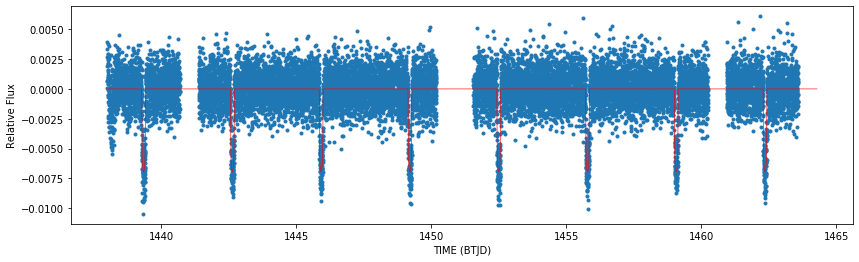

In [0]:
detrend = data['LC_DETREND']
model = data['MODEL_INIT']
time = data['TIME']

plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')

<a id="phased"></a>
## Request a Bokeh Phased Light Curve
The API allows you to pull down a Bokeh plot of the phased light curve, folded and binned at the period of the identified TCE.  Bokeh provides a zoomable, pannable plot to examine. 

In [0]:
url = dvurl + str(ticid) + '/phaseplot/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)

In [0]:
display(HTML(str(r.content.decode('utf-8'))))

<a id="about_ID"></a>
## About this Notebook
**Author:** Susan E. Mullally, STScI Archive Scientist
<br>**Updated On:** 2018-12-04

[Top of Page](#top_page)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 